In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [2]:

# ---------------------------
# Device config
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:

# ---------------------------
# Hyperparameters
# ---------------------------
batch_size = 32
learning_rate = 0.001
num_epochs = 15
image_size = 224


In [6]:

# ---------------------------
# Transforms and Dataset
# ---------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

class_names = train_dataset.classes
num_classes = len(class_names)


In [7]:

# ---------------------------
# Define the Basic CNN model
# ---------------------------
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (image_size//8) * (image_size//8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = BasicCNN(num_classes).to(device)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Acc: {train_accuracies[-1]*100:.2f}%, "
          f"Val Acc: {val_accuracies[-1]*100:.2f}%")


Epoch [1/15], Train Acc: 59.46%, Val Acc: 77.41%
Epoch [2/15], Train Acc: 79.17%, Val Acc: 94.77%
Epoch [3/15], Train Acc: 85.82%, Val Acc: 97.41%
Epoch [4/15], Train Acc: 89.17%, Val Acc: 99.11%
Epoch [5/15], Train Acc: 91.17%, Val Acc: 99.14%
Epoch [6/15], Train Acc: 92.58%, Val Acc: 99.38%
Epoch [7/15], Train Acc: 93.73%, Val Acc: 98.94%
Epoch [8/15], Train Acc: 94.37%, Val Acc: 99.61%
Epoch [9/15], Train Acc: 95.41%, Val Acc: 99.34%
Epoch [10/15], Train Acc: 95.42%, Val Acc: 99.30%
Epoch [11/15], Train Acc: 95.83%, Val Acc: 98.94%
Epoch [12/15], Train Acc: 96.46%, Val Acc: 99.80%
Epoch [13/15], Train Acc: 96.57%, Val Acc: 99.14%
Epoch [14/15], Train Acc: 96.87%, Val Acc: 99.66%
Epoch [15/15], Train Acc: 97.05%, Val Acc: 99.86%


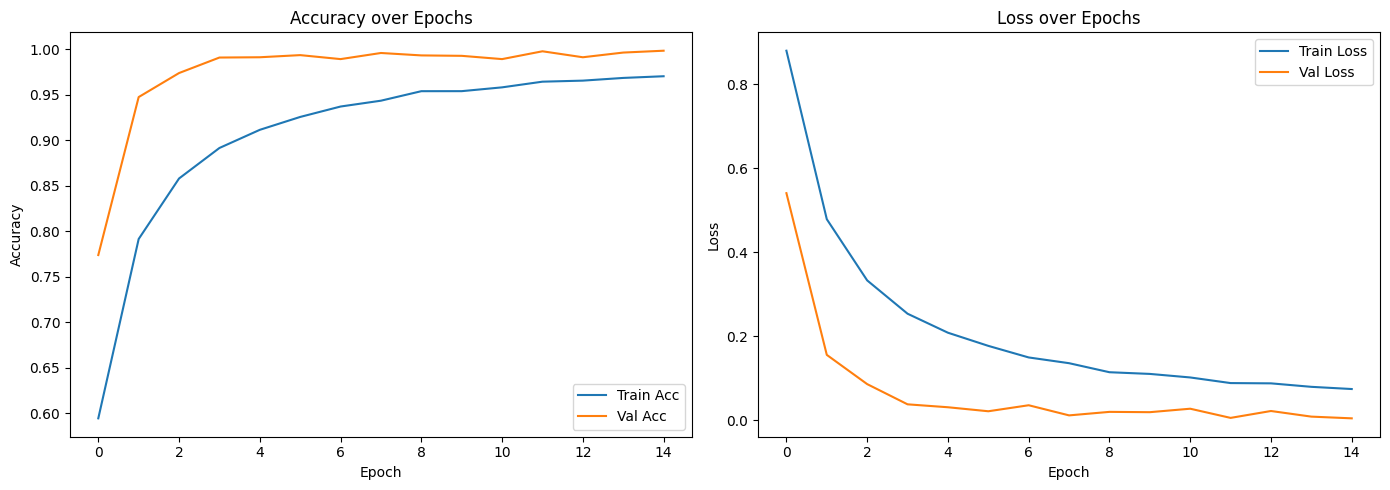

In [9]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


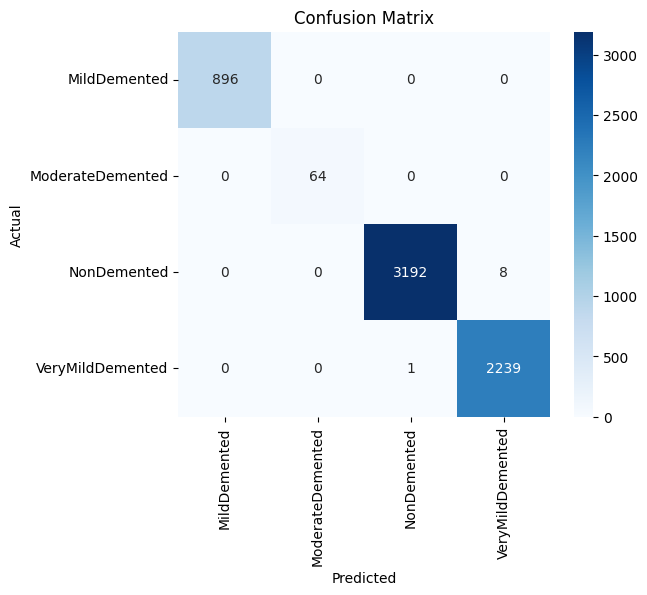

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       896
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       1.00      1.00      1.00      3200
VeryMildDemented       1.00      1.00      1.00      2240

        accuracy                           1.00      6400
       macro avg       1.00      1.00      1.00      6400
    weighted avg       1.00      1.00      1.00      6400



In [10]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [11]:
# Save entire model (architecture + weights)
torch.save(model, "alzheimers_cnn_full_model.pth")

# OR Save only the model weights (recommended)
torch.save(model.state_dict(), "alzheimers_cnn_weights.pth")


In [12]:
model = torch.load("alzheimers_cnn_full_model.pth")
model.eval()


C:\Users\molim\AppData\Local\Temp\ipykernel_38236\3243788327.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("alzheimers_cnn_full_model.pth")


BasicCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)